<a href="https://colab.research.google.com/github/glaria/TFM/blob/main/Colab%20Notebooks/4_TFM_models_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Métodos ensemble

Podemos en primer lugar probar con los algoritmos construidos en el notebook previo (LDA, Perceptron, Arbol de decision y SVM)

# Carga del dataset

In [ ]:
from google.colab import drive
import os
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns


drive.mount('/content/gdrive')

dataset_path = '/content/gdrive/MyDrive/malware_datasets/balanced_df.csv'

df = pd.read_csv(dataset_path)


Mounted at /content/gdrive


Ahora haremos el split aleatorio en train-validation-test



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

X = df.drop(['Malware', 'data_source'], axis=1) #quitamos columnas no numericas y las etiquetas
y = df['Malware']

#creamos los conjuntos de train, test y validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_ratio + validation_ratio), random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)


#reescalamos los datos (util para algunos algoritmos)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)


Definimos las funciones creadas en el otro notebook

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=5):
    metrics = {
        'f1': 'f1',
        'precision': 'precision',
        'accuracy': 'accuracy',
        'recall': 'recall'
    }

    #Validacion cruzada en el conjunto train
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=metrics, return_train_score=True)

    #entrenamos el modelo
    model.fit(X_train, y_train)

    #resultados en el conjunto de test

    y_pred = model.predict(X_test)
    test_results = {
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    return cv_results, test_results

def print_mean_scores(cv_results, model_name, pca_used=False):
  if pca_used == True:
    print(f'Model: {model_name} with PCA')
    for metric, scores in cv_results[0].items():
        print(f'{metric}: {scores.mean()}')
    print('')
    print(f' {model_name} - test-PCA')
    for metric, scores in cv_results[1].items():
        print(f'{metric}: {scores.mean()}')
    print('')
  else:
    print(f'Model: {model_name}')
    for metric, scores in cv_results[0].items():
        print(f'{metric}: {scores.mean()}')
    print('')
    print(f' {model_name} - test')
    for metric, scores in cv_results[1].items():
        print(f'{metric}: {scores.mean()}')
    print('')  

def plot_results(model, X_train, y_train, X_test, y_test, model_name):
    print(f"Modelo: {model_name}")

    #matriz de confusión (mejor visualización)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
    plt.title(f"Matriz de confusión ({model_name})")
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.show()

Entrenamos los algoritmos obtenidos anteriormente

In [ ]:

perceptron = Perceptron(random_state=42) 
perceptron_cv_results = evaluate_model(perceptron, X_train, y_train, X_test, y_test) #no podemos usar perceptron con pca, porque dt y svm no se entrenaron sobre datos proyectados

#mejores Arbol de decision & SVM
best_dt = DecisionTreeClassifier(max_depth=30, min_samples_leaf=10, min_samples_split=5,
                       random_state=42)
best_svm = LinearSVC(C=1, loss = 'squared_hinge', class_weight=None, dual=False, max_iter=1000,
          random_state=42)


#entrenamos y evaluamos SVM y DT utilizando validación cruzada
best_dt_results = evaluate_model(best_dt, X_train, y_train, X_test, y_test)
best_svm_results = evaluate_model(best_svm, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Ahora construimos un método ensemble simple usando el VotingClassifier.
Cada modelo clasifica los datos por separado y luego votan para decidir la clasificación.
Usaremos el mejor árbol de decisión obtenido, la mejor máquina de vectores soporte y el perceptrón
le asignamos un peso mayor en la votación al árbol de decisión (1.5), dado que fue el algoritmo con los mejores resultados, así que un voto de DT solo sería anulado por una decisión unánime y contraria de los otros 2 algoritmos

In [ ]:
#creamos el clasificador de votación usando los modelos Perceptron, SVM y Árbol de decisión, y se asignan los pesos
from sklearn.ensemble import VotingClassifier

voting_clf_weighted = VotingClassifier(
    estimators=[
        ("perceptron", perceptron),
        ("svm", best_svm),
        ("dt", best_dt)
    ],
    voting="hard",  
    weights=[1, 1, 2],  #asignamos un peso mayor al árbol de decisión
    n_jobs=-1
)

#se entrena el nuevo clasificador de votación con pesos
voting_clf_weighted.fit(X_train, y_train)


VotingClassifier(estimators=[('perceptron', Perceptron(random_state=42)),
                             ('svm',
                              LinearSVC(C=1, dual=False, random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=30,
                                                     min_samples_leaf=10,
                                                     min_samples_split=5,
                                                     random_state=42))],
                 n_jobs=-1, weights=[1, 1, 2])

el perceptron no tiene metodo predict_proba, lo que obliga a usar votacion hard y por tanto el modelo ensemble no genera el atributo decision_function que es necesario para calcular el area bajo la curva ROC.
Por ello, no podemos usar ni plot_results ni evaluate model para el método ensemble que incluya al perceptron

In [ ]:
#predicciones en el conjunto test
y_pred = voting_clf_weighted.predict(X_test)

#se calculan las metricas y la matriz de confusion
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

conf_mat = confusion_matrix(y_test, y_pred)

print(f"F1: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("Matriz de confusión:")
print(conf_mat)


F1: 0.950
Accuracy: 0.952
Precision: 0.966
Recall: 0.935
Matriz de confusión:
[[3030  101]
 [ 199 2859]]


obtenemos una ligera mejora en la precisión que se refleja en el menor número de flasos positivos, pero a costa de aumentar los falsos negativos, y por tanto, empeorar de forma significativa la exactitud

#Random forest
probemos ahora con métodos ensemble implementados en librerías de python, empezamos con random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# entrenamos RandomForest
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

#evaluación del modelo en el conjunto de validación
rfc_evaluate = evaluate_model(rfc, X_train, y_train, X_test, y_test)

print_mean_scores(rfc_evaluate, 'Random Forest')
print('Matriz de confusión (test)')
print(rfc_evaluate[1]['confusion_matrix'])


Model: Random Forest
fit_time: 1.9486339569091797
score_time: 0.07138323783874512
test_f1: 0.9779388762463344
train_f1: 0.999896133871531
test_precision: 0.9766596379039564
train_precision: 0.9999307569131004
test_accuracy: 0.9779064587305584
train_accuracy: 0.9998961113916313
test_recall: 0.979227708693497
train_recall: 0.9998615153250336

 Random Forest - test
f1: 0.9751633986928104
precision: 0.9745264532984977
accuracy: 0.9754402973016643
recall: 0.9758011772400261
confusion_matrix: 1547.25

Matriz de confusión (test)
[[3053   78]
 [  74 2984]]


Evaluamos en el conjunto test

Resultados gráficos

Modelo: Random Forest


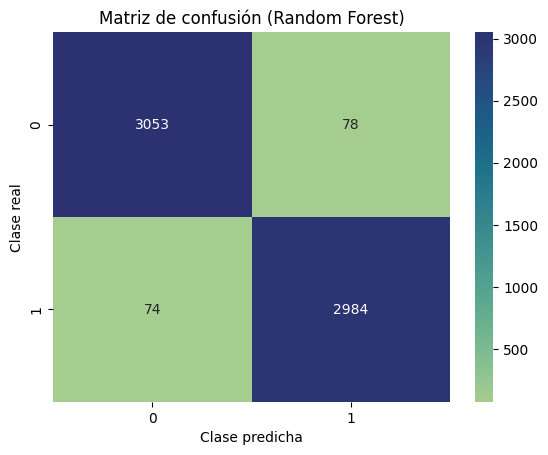

In [ ]:
rfc.fit(X_train, y_train)
plot_results(rfc, X_train, y_train, X_test, y_test, 'Random Forest')

#optimizar randomforest con busqueda aleatoria

In [ ]:
from scipy.stats import randint


#definimos los hiperparametros que serán usados en la busqueda aleatoria
param_dist = {
    'n_estimators': randint(250, 400),     
    'criterion': ['gini'],
    'min_samples_split': randint(2, 4),    #Alrededor de 2 (valor por defecto)
    'min_samples_leaf': randint(1, 3),      #Cercano a 1
}

#se define el modelo base
base_rfc = RandomForestClassifier(random_state=42)

#búsqueda aleatoria sobre los parametros definidos
random_search_rfc = RandomizedSearchCV(estimator=base_rfc, param_distributions=param_dist, n_iter=40, cv=5,scoring='recall', verbose=4, random_state=42, n_jobs=-1)

#entrenamos
random_search_rfc.fit(X_train, y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'criterion': ['gini'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f6a78ab3cd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f6a79f07550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f6a79317280>},
                   random_state=42, scoring='recall', verbose=4)

In [ ]:

#mejores hiperparámetros encontrados
print("Best parameters:")
print(random_search_rfc.best_params_)

#entrenamos y evaluamos el modelo con los mejores hiperparámetros
best_rfc = random_search_rfc.best_estimator_

best_rfc_evaluate = evaluate_model(best_rfc, X_train, y_train, X_test, y_test)

print_mean_scores(best_rfc_evaluate, 'Random Forest')
print('Matriz de confusión (test)')
print(best_rfc_evaluate[1]['confusion_matrix'])

Best parameters:
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Model: Random Forest
fit_time: 8.689651823043823
score_time: 0.22453804016113282
test_f1: 0.9781928139658358
train_f1: 0.9998961346208827
test_precision: 0.9764061272124416
train_precision: 0.9999134468905974
test_accuracy: 0.9781488529937283
train_accuracy: 0.9998961113916313
test_recall: 0.9799893377209763
train_recall: 0.9998788268458506

 Random Forest - test
f1: 0.9758248938255472
precision: 0.9748694516971279
accuracy: 0.9760866052674099
recall: 0.9767822105951602
confusion_matrix: 1547.25

Matriz de confusión (test)
[[3054   77]
 [  71 2987]]


Modelo: Random Forest


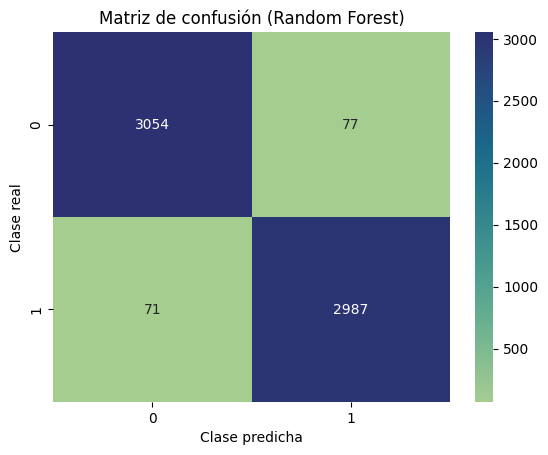

In [ ]:
best_rfc.fit(X_train, y_train)

plot_results(best_rfc, X_train, y_train, X_test, y_test, 'Random Forest')

# Gradient Boosting


In [ ]:
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# configuramos los parámetros
param = {
    'max_depth': 7,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'gamma': 0,
    'eval_metric': 'logloss',
    'subsample': 1.0, 
    'min_child_weight': 1, 
    'learning_rate': 0.05, 
    'colsample_bytree': 0.7
}

num_round = 10  # número de iteraciones

# entrenamos el modelo
bst = xgb.train(param, dtrain, num_round)

# predecimos las puntuaciones de clase en el conjunto de prueba
y_test_scores = bst.predict(dtest)

# aplicamos un umbral a las puntuaciones de clase para obtener las etiquetas de clase predichas
y_test_pred = (y_test_scores > 0.5).astype(int)

# calculamos las métricas de evaluación
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: 0.9591210211665859
Precision: 0.9572872513857189
Recall: 0.9601046435578809
F1: 0.9586938775510203


probamos con random search

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

#modelo XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.9, 1.0],
    'max_depth': [5, 7, 9],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0,5]
}

# Utilizamos RandomizedSearchCV para buscar los mejores hiperparámetros
clf = RandomizedSearchCV(xgb_model, 
                         param_distributions = param_dist, 
                         cv = 5,  
                         n_iter = 20, 
                         scoring = 'f1', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train, y_train)

# mejores parámetros
print("Mejores parámetros: ", clf.best_params_)
print("Mejor score: ", clf.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros:  {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Mejor score:  0.9787274405456868


entrenamos el mejor modelo obtenido

In [ ]:
# construimos y entrenamos el modelo con los mejores hiperparámetros
best_params = clf.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

#métricas

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9770560672160284
Precision: 0.9733766233766233
Recall: 0.9803793328973185
F1: 0.9768654284783317
Confusion Matrix:
[[3049   82]
 [  60 2998]]


Dibujamos el xgboost

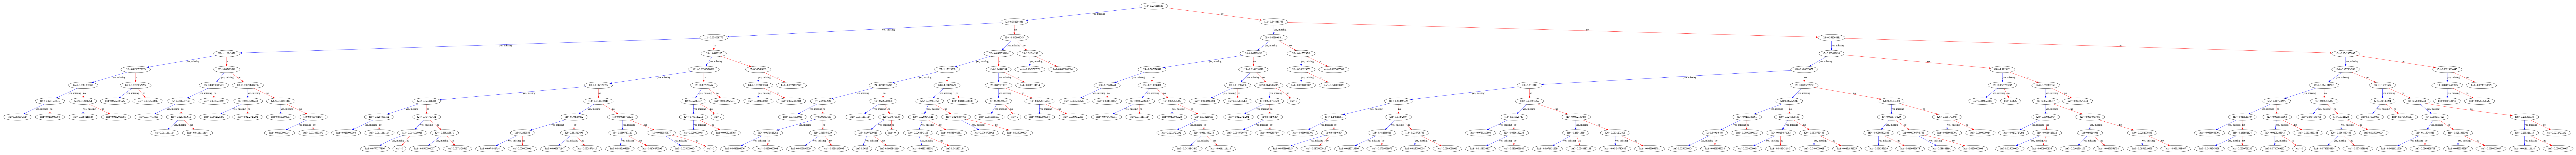

In [ ]:
from matplotlib import pyplot

xgb.plot_tree(best_xgb_model)
fig = pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

Modelo: XGBoost


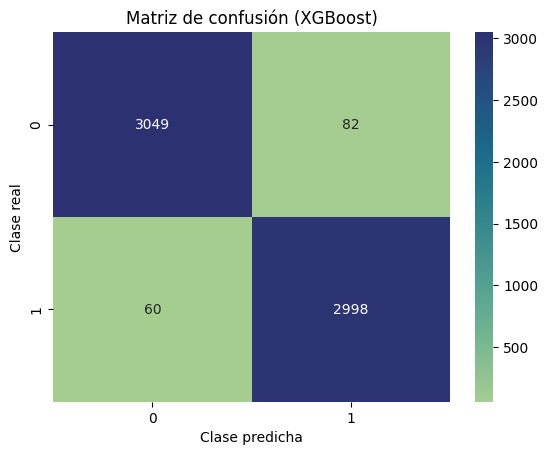

In [ ]:
plot_results(best_xgb_model, X_train, y_train, X_test, y_test, 'XGBoost')